In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS

In [23]:
tickers = ["RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS"]

In [29]:
start_date = "2015-01-01"
end_date = "2024-06-28"

data = {}

for ticker in tickers:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    df = stock_data['Adj Close'].reset_index().rename(columns={'Date': 'ds', 'Adj Close': 'y'})
    df['unique_id'] = ticker
    data[ticker] = df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
def prepare_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

train_end_date = '2023-01-01'
train_data = {}
test_data = {}

for ticker in tickers:
    train_data[ticker], test_data[ticker] = prepare_data(data[ticker], train_end_date)

In [31]:
def forecast_stock_neural(df_train, df_test, horizon=30):
    models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
              NHITS(input_size=2 * horizon, h=horizon, max_steps=50)]
    
    nf = NeuralForecast(models=models, freq='D')
    nf.fit(df=df_train)
    Y_hat_df = nf.predict().reset_index()
    
    return Y_hat_df

Seed set to 1
Seed set to 1


Forecasting for RELIANCE.NS...


/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /home/bhanuj/Desktop/forecast_model/lightning_logs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 5.6 M  | train
-------------------------------------------------------
4.8 M     Trainable params
796 K     Non-trainable params
5.6 M     Total params
22.351    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, v_num=0, train_loss_step=172.0, train_loss_epoch=170.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s, v_num=0, train_loss_step=172.0, train_loss_epoch=172.0]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s, v_num=0, train_loss_step=172.0, train_loss_epoch=172.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.6 M  | train
-------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.232    Total estimated model params size (MB)



Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s, v_num=1, train_loss_step=158.0, train_loss_epoch=155.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s, v_num=1, train_loss_step=158.0, train_loss_epoch=158.0]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s, v_num=1, train_loss_step=158.0, train_loss_epoch=158.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.81it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.11it/s]


/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

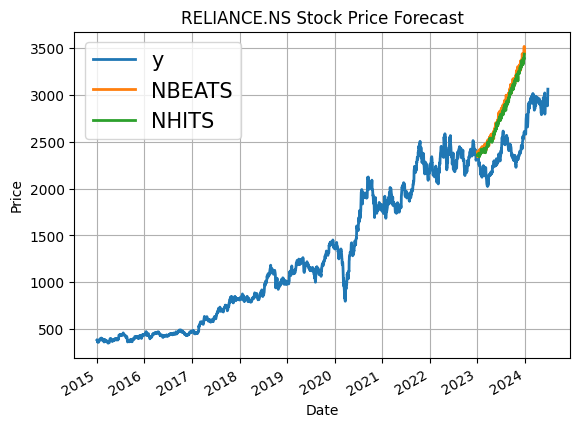

Seed set to 1
Seed set to 1
/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 5.6 M  | train
-------------------------------------------------------
4.8 M     Trainable params
796 K     Non-trainable params
5.6 M     Total params
22.351    Total estimated model params size (MB)


Forecasting for TCS.NS...
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, v_num=4, train_loss_step=212.0, train_loss_epoch=213.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s, v_num=4, train_loss_step=212.0, train_loss_epoch=212.0]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s, v_num=4, train_loss_step=212.0, train_loss_epoch=212.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.6 M  | train
-------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.232    Total estimated model params size (MB)



Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s, v_num=5, train_loss_step=160.0, train_loss_epoch=160.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s, v_num=5, train_loss_step=160.0, train_loss_epoch=160.0]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s, v_num=5, train_loss_step=160.0, train_loss_epoch=160.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.25it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.94it/s]


/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

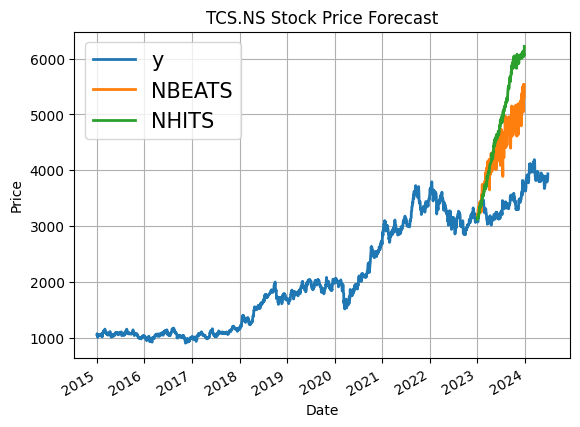

Seed set to 1
Seed set to 1
/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 5.6 M  | train
-------------------------------------------------------
4.8 M     Trainable params
796 K     Non-trainable params
5.6 M     Total params
22.351    Total estimated model params size (MB)


Forecasting for INFY.NS...
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s, v_num=8, train_loss_step=103.0, train_loss_epoch=108.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, v_num=8, train_loss_step=103.0, train_loss_epoch=103.0]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, v_num=8, train_loss_step=103.0, train_loss_epoch=103.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.6 M  | train
-------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.232    Total estimated model params size (MB)



Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s, v_num=9, train_loss_step=75.90, train_loss_epoch=75.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s, v_num=9, train_loss_step=75.90, train_loss_epoch=75.90]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, v_num=9, train_loss_step=75.90, train_loss_epoch=75.90]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.76it/s] 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.99it/s]


/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

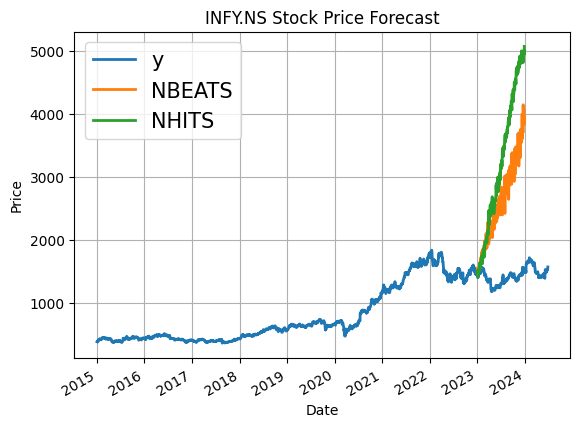

Seed set to 1
Seed set to 1
/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 5.6 M  | train
-------------------------------------------------------
4.8 M     Trainable params
796 K     Non-trainable params
5.6 M     Total params
22.351    Total estimated model params size (MB)


Forecasting for HDFCBANK.NS...
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s, v_num=12, train_loss_step=130.0, train_loss_epoch=128.0]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s, v_num=12, train_loss_step=130.0, train_loss_epoch=130.0]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, v_num=12, train_loss_step=130.0, train_loss_epoch=130.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.6 M  | train
-------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.232    Total estimated model params size (MB)



Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s, v_num=13, train_loss_step=103.0, train_loss_epoch=102.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s, v_num=13, train_loss_step=103.0, train_loss_epoch=103.0]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s, v_num=13, train_loss_step=103.0, train_loss_epoch=103.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.05it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.28it/s]


/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

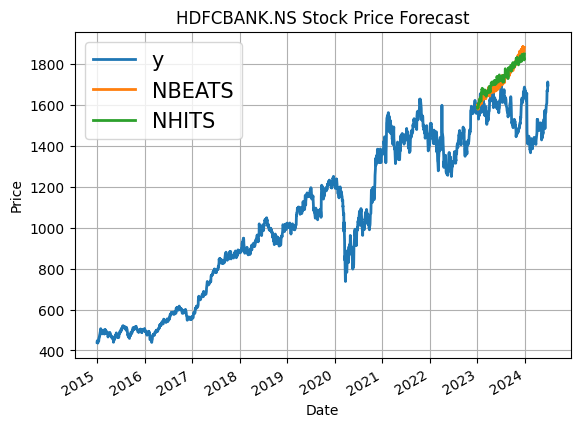

Seed set to 1
Seed set to 1
/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 5.6 M  | train
-------------------------------------------------------
4.8 M     Trainable params
796 K     Non-trainable params
5.6 M     Total params
22.351    Total estimated model params size (MB)


Forecasting for ICICIBANK.NS...
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s, v_num=16, train_loss_step=65.80, train_loss_epoch=65.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s, v_num=16, train_loss_step=65.80, train_loss_epoch=65.80]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s, v_num=16, train_loss_step=65.80, train_loss_epoch=65.80]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.6 M  | train
-------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.232    Total estimated model params size (MB)



Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s, v_num=17, train_loss_step=55.90, train_loss_epoch=56.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, v_num=17, train_loss_step=55.90, train_loss_epoch=55.90]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, v_num=17, train_loss_step=55.90, train_loss_epoch=55.90]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.50it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.61it/s]


/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

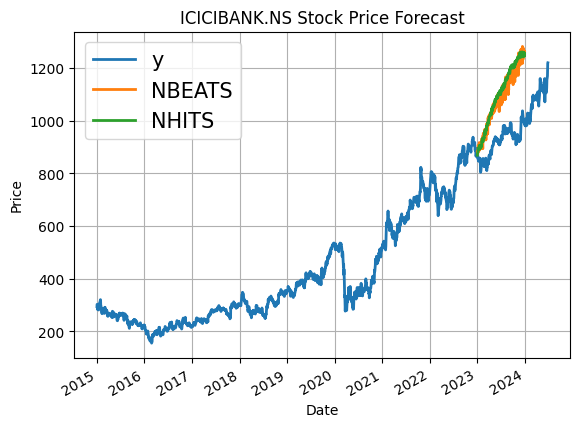

In [32]:
for ticker in tickers:
    print(f"Forecasting for {ticker}...")
    
    train_df = train_data[ticker]
    test_df = test_data[ticker]
    horizon = len(test_df)
    
    Y_hat_df = forecast_stock_neural(train_df, test_df, horizon=horizon)
    
    # Merge forecast with test data for plotting
    Y_hat_df = test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
    plot_df = pd.concat([train_df, Y_hat_df]).set_index('ds')

    # Plotting
    plt.figure(figsize=(10, 6))
    plot_df[['y', 'NBEATS', 'NHITS']].plot(linewidth=2)
    plt.title(f'{ticker} Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(prop={'size': 15})
    plt.grid()
    plt.show()

In [34]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import RNN
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

# Assuming AirPassengersPanel and AirPassengersStatic are already defined or imported

# Ensure 'ds' column is datetime and sorted
AirPassengersPanel['ds'] = pd.to_datetime(AirPassengersPanel['ds'])  # Convert 'ds' to datetime
AirPassengersPanel = AirPassengersPanel.sort_values(by='ds')  # Ensure data is sorted by 'ds'

# Split into train and test sets
Y_train_df = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]]  # Training data
Y_test_df = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)  # Test data

# Define and train NeuralForecast model
fcst = NeuralForecast(
    models=[RNN(h=12,
                input_size=-1,
                inference_input_size=24,
                loss=MQLoss(level=[80, 90]),
                scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_steps=300,
                futr_exog_list=['y_[lag12]'],
                stat_exog_list=['airline1'],
                )
    ],
    freq='M'  # Adjust frequency as per your dataset
)

# Fit the model
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot forecasts
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)

plot_df = plot_df[plot_df.unique_id == 'Airline1'].drop('unique_id', axis=1)
plt.figure(figsize=(10, 6))
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['RNN-median'], c='blue', label='Median Forecast')
plt.fill_between(plot_df['ds'], plot_df['RNN-lo-90'], plot_df['RNN-hi-90'], alpha=0.4, color='blue', label='90% Confidence Interval')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecasting with NeuralForecast RNN Model')
plt.show()

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 49.9 K | train
4 | context_adapter | Linear        | 16.9 K | train
5 | mlp_decoder     | MLP           | 2.2 K  | train
----------------------------------------------------------
69.0 K    Trainable params
5         Non-trainable params
69.0 K    Total params
0.276     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.68it/s, v_num=20, train_loss_step=0.0425, train_loss_epoch=0.0431]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s, v_num=20, train_loss_step=0.021, train_loss_epoch=0.0209, valid_loss=9.470] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s, v_num=20, train_loss_step=0.0199, train_loss_epoch=0.0204, valid_loss=12.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s, v_num=20, train_loss_step=0.0199, train_loss_epoch=0.0199, valid_loss=12.70]

`Trainer.fit` stopped: `max_steps=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s, v_num=20, train_loss_step=0.0199, train_loss_epoch=0.0199, valid_loss=12.70]


/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/utilsforecast/processing.py:382: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/utilsforecast/processing.py:436: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


ValueError: There are missing combinations of ids and times in `futr_df`.
You can run the `make_future_dataframe()` method to get the expected combinations or the `get_missing_future(futr_df)` method to get the missing combinations.